# Módulo 3. Introducción al aprendizaje supervisado

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%precision 5

import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({"figure.figsize": (10,7)}) 

## Regresión polinomial

Comenzamos por definir nuestra función de referencia y graficarla para distintos niveles de "ruido".

In [2]:
def create_sinusoidal_data(noise=0.25, num_samples=50):    
    x = np.linspace(0, 1, num_samples)
    y = np.sin(2 * np.pi * x) + np.random.normal(scale=noise, size=x.shape)
    return x, y

[]

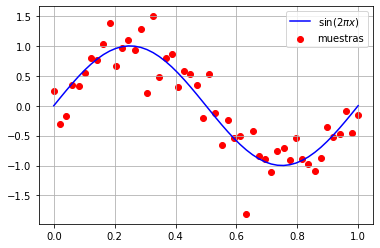

In [5]:
np.random.seed(1234)
x1, y1 = create_sinusoidal_data(0.0, 50)  # sin ruido, solo para referencia
x2, y2 = create_sinusoidal_data(0.3, 50)  # ruido gaussiano con una varianza de 0.3**2
plt.plot(x1, y1, color="blue", label="$\sin(2\pi x)$")
plt.scatter(x2, y2, color="red", label="muestras")
plt.legend()
plt.grid()
plt.plot()

## Conjuntos de entrenamiento, validación y test

Construcción de conjuntos de entrenaminento, validación y test o evaluación

In [6]:
X, Y = np.array(x2), np.array(y2)  # tomamos el segundo conjunto definido anteriormente

n_samples = len(X)  # número total de muestras

n_trainval = int(0.8 * n_samples)  # 80% de muestras para entrenamineto y validación
n_test = n_samples - n_trainval  # el resto como muestras de test
print(f"{n_trainval} muestras de entrenamiento+validación, {n_test} muestras de test")

40 muestras de entrenamiento+validación, 10 muestras de test


[ 5 16 29  6 30 31 28 13 27  7  0 48 45 33 46 49  4 14  1 42  2 26 20 10
  3 43 11 36 15  9 35 37 41 40 18 17 19 22 21 47 23  8 32 44 12 24 39 25
 34 38]


[]

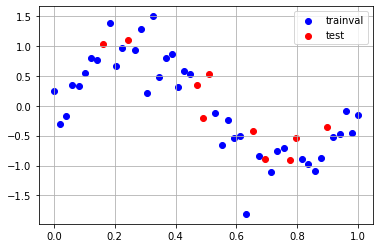

In [7]:
# permutación de los índices entre 0 y N_SAMPLES-1
idxs = np.random.permutation(n_samples)
print(idxs)

# subconjunto de índices (permutados) que corrresponden al conjunto trainval
idxs_trainval = idxs[:n_trainval]  
X_trainval, Y_trainval = X[idxs_trainval], Y[idxs_trainval]

# idem test
idxs_test = idxs[n_trainval:]  
X_test, Y_test = X[idxs_test], Y[idxs_test]

# graficamos estos subconjuntos (disjuntos)
plt.scatter(X_trainval, Y_trainval, color="blue", label="trainval")
plt.scatter(X_test, Y_test, color="red", label="test")
plt.legend()
plt.grid()
plt.plot()

Como vimos, el conjunto "trainval" es el único que debemos utilizar para el entrenamiento de los modelos. Para hacer ajuste de los hiperparámetros (p.ej. orden del polinomio) debemos contar con un conjunto auxiliar de validación. Para ello repetiremos el proceso de indexado aleatorio y particionado sobre el conjunto trainval

In [9]:
n_train = int(0.8 * n_trainval)
n_val = n_trainval - n_train
print(f"{n_train} muestras de entrenamiento, {n_val} muestras de validación")

idxs = np.random.permutation(n_trainval)  # IMPORTANTE: los índices son sobre el conjunto trainval!

idxs_train = idxs[:n_train]  
X_train, Y_train = X_trainval[idxs_train], Y_trainval[idxs_train]

idxs_val = idxs[n_train:]  
X_val, Y_val = X_trainval[idxs_val], Y_trainval[idxs_val]

32 muestras de entrenamiento, 8 muestras de validación


[]

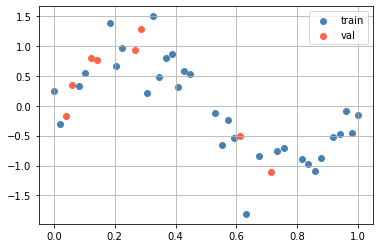

In [10]:
# graficamos estos subconjuntos (disjuntos)
plt.scatter(X_train, Y_train, color="steelblue", label="train")
plt.scatter(X_val, Y_val, color="tomato", label="val")
plt.legend()
plt.grid()
plt.plot()

## Características polinomiales

Hasta ahora tenemos nuestra señal unidimensional muestreada a intervalos regulares en [0,1]. Cada par (x,y) corresponde a un escalar (x) y su valor objetivo (y). Como vimos, podemos transformar el problema y representar cada x como un vector de potencias de x. Esto nos permite generalizar el problema y tratarlo como uno lineal en N dimensiones.

In [12]:
def polynomial_features(X, M):
    assert isinstance(X, np.ndarray)    
    X = X.reshape(-1, 1)
    return np.concatenate([X**m for m in range(M+1)], axis=1)
    
#M = 5
#X_train_ = polynomial_features(X_train, M)  # conjunto de entrenamiento
#print(X_train_.shape, Y_train.shape)
#X_val = polynomial_features(X_val, M)  # conjunto de validación
#print(X_val.shape, Y_val.shape)
#X_test = polynomial_features(X_test, M)  # conjunto de test: para evaluación FINAL
#print(X_test.shape, Y_test.shape)

(32, 6) (32,)


## Entrenamiento, selección de hyperparámetros y evaluación

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

registry = [] 

for M in range(20):
    X_train_ = polynomial_features(X_train, M)
    X_val_ = polynomial_features(X_val, M)

    model = LinearRegression(fit_intercept=False)  # el término de bias ya está incorporado (potencia 0 del poly)
    model.fit(X_train_, Y_train)
    
    Y_train_pred = model.predict(X_train_)
    train_err = mean_squared_error(Y_train, Y_train_pred)
    
    Y_val_pred = model.predict(X_val_)
    val_err = mean_squared_error(Y_val, Y_val_pred)
    
    wnorm = np.linalg.norm(model.coef_[1:])  
    
    registry.append([M, train_err, val_err])    
    
    print(f"M={M}, error (train): {train_err:.5f}, error (val): {val_err:.5f}, w-norm: {wnorm:.5f}")        

M=0, error (train): 0.58085, error (val): 0.71590, w-norm: 0.00000
M=1, error (train): 0.33524, error (val): 0.36086, w-norm: 1.64453
M=2, error (train): 0.33486, error (val): 0.35353, w-norm: 1.41715
M=3, error (train): 0.11629, error (val): 0.04362, w-norm: 42.10043
M=4, error (train): 0.11599, error (val): 0.04331, w-norm: 49.29685
M=5, error (train): 0.10407, error (val): 0.03861, w-norm: 260.32747
M=6, error (train): 0.10353, error (val): 0.03760, w-norm: 606.39174
M=7, error (train): 0.10351, error (val): 0.03827, w-norm: 389.64437
M=8, error (train): 0.10125, error (val): 0.03518, w-norm: 23677.40581
M=9, error (train): 0.08035, error (val): 0.10226, w-norm: 448486.81851
M=10, error (train): 0.07997, error (val): 0.09856, w-norm: 212199.65843
M=11, error (train): 0.07868, error (val): 0.11628, w-norm: 2769555.98670
M=12, error (train): 0.07468, error (val): 0.07821, w-norm: 32855705.49718
M=13, error (train): 0.06882, error (val): 0.18586, w-norm: 251837915.68201
M=14, error (tr

mejor M=8.0


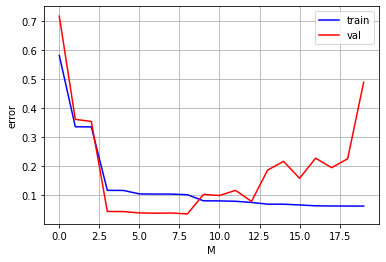

In [18]:
# obtener el valor de M que resultó en el menor error cuadrático
registry = np.array(registry)
best_idx = np.argmin(registry[:, 2])
print(f"mejor M={registry[best_idx][0]}")

plt.plot(registry[:, 0], registry[:, 1], color="blue", label="train")
plt.plot(registry[:, 0], registry[:, 2], color="red", label="val")
plt.legend()
plt.grid()
plt.xlabel("M")
plt.ylabel("error")
plt.show()


In [19]:
# entrenar el modelo final. Puede ser sobre el conjunto trainval para aprovechar las muestras de entrenamiento disponibles
best_M = 6
X_trainval_ = polynomial_features(X_trainval, best_M)
X_test_ = polynomial_features(X_test, best_M)
model = LinearRegression(fit_intercept=False)  # el término de bias ya está incorporado (potencia 0 del poly)
model.fit(X_trainval_, Y_trainval)

Y_test_pred = model.predict(X_test_)
err = mean_squared_error(Y_test, Y_test_pred)
print(f"test error: {err:.5f}")

test error: 0.11279


Graficamos:

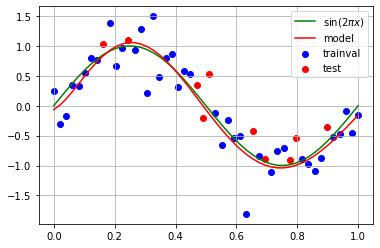

In [20]:
plt.scatter(X_trainval, Y_trainval, color="blue", label="trainval")
plt.scatter(X_test, Y_test, color="red", label="test")

X, Y = np.array(x1), np.array(y1)
Y_pred = model.predict(polynomial_features(X, best_M))

plt.plot(X, Y, color="green", label="$\sin(2\pi x)$")
plt.plot(X, Y_pred, color="red", label="model")
plt.legend()
plt.grid()
plt.show()

FIN